## How to find a planet in Kepler data using **lightkurve**

This tutorial demonstrates the basics steps required to identify a transiting planet candidate in the Kepler data.

In what follows, we will show how you can recover the signal of [Kepler-10b](https://en.wikipedia.org/wiki/Kepler-10b), the first rocky planet that was discovered by Kepler!
Kepler-10 is a Sun-like (G-type) star approximately 600 light years away in the constellation of Cygnus. In this tutorial, we will download the pixel data of Kepler-10, extract a lightcurve, and recover the planet.

First, let's load two popular scientific Python packages: numpy (for numerical operations) and matplotlib (for plotting).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Kepler pixel data is distributed in so-called "Target Pixel File".  The `lightkurve` package provides a `KeplerTargetPixelFile` class which enables you to load and interact with data in this format.

The class can take a path (local or url), or you can load data straight from the archive as follows:


In [2]:
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive("Kepler-10", quarter=3)

INFO: Found cached file ./mastDownload/Kepler/kplr011904151_lc_Q111111110111011101/kplr011904151-2009350155506_lpd-targ.fits.gz with expected size 8025577. [astroquery.query]


Note: If you want to know details about the *KeplerTargetPixelFile* class, please see the target pixel file tutorial [ADD LINK FOR THE TUTORIAL].

Let's use the `plot` method and pass along an aperture mask and a few plotting arguments.

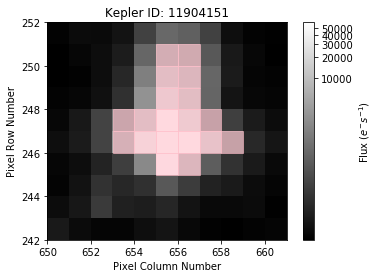

In [3]:
tpf.plot(aperture_mask=tpf.pipeline_mask, scale='log', cmap='gray');

Now, we will use the ``to_lightcurve`` method to create a simple aperture photometry lightcurve using the
mask defined by the pipeline which is stored in `tpf.pipeline_mask`.

In [4]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

Let's take a look at the output lightcurve.

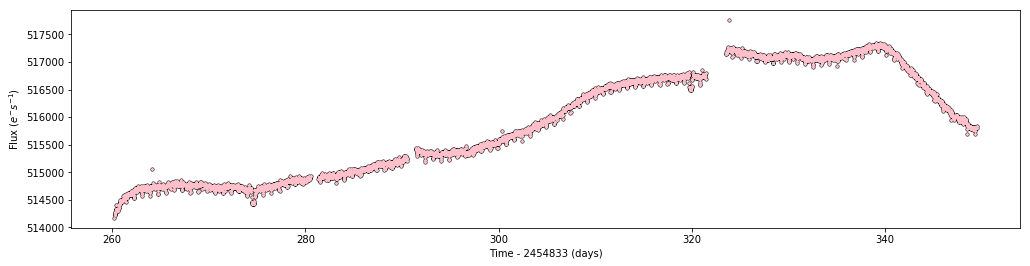

In [5]:
plt.figure(figsize=(17, 4))
plt.plot(lc.time, lc.flux, 'ko', markersize=3)
plt.plot(lc.time, lc.flux, 'o', color='pink', markersize=2)
plt.ylabel(r"Flux $(e^{-}s^{-1})$")
plt.xlabel(r"Time - 2454833 (days)");

Now let's use the `flatten` method, which applies a Savitzky-Golay filter, to remove long-term variability that we are not interested in. 

In [6]:
flat, trend = lc.flatten(return_trend=True)

Let's plot the trend estimated by the Savitzky-Golay filter:

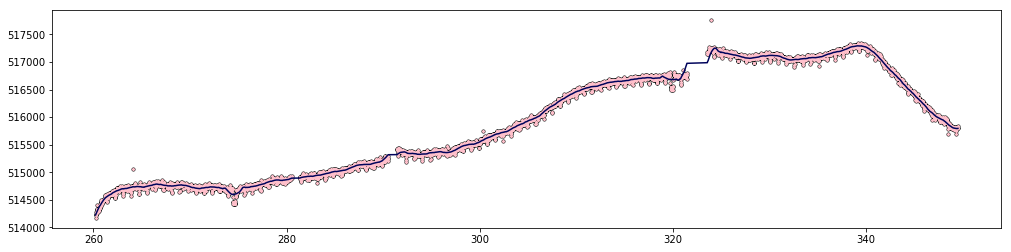

In [7]:
plt.figure(figsize=(17, 4))
plt.plot(lc.time, lc.flux, 'ko', markersize=3)
plt.plot(lc.time, lc.flux, 'o', color='pink', markersize=2)
plt.plot(trend.time, trend.flux, color='#00035b');

and the flat lightcurve:

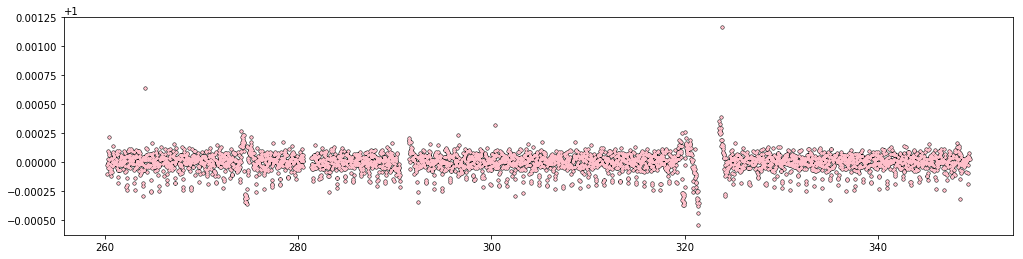

In [8]:
plt.figure(figsize=(17, 4))
plt.plot(flat.time, flat.flux, 'ko', markersize=3)
plt.plot(flat.time, flat.flux, 'o', color='pink', markersize=2);

The trending algorithm exhibits a large bias at jumps of missing data, but such jumps will merely add a few outliers.

Now, let's run a period search function similiar to the Box-Least Squares algorithm (http://adsabs.harvard.edu/abs/2002A%26A...391..369K):

In [9]:
from lightkurve import iterative_box_period_search
prob, periods, best_period = iterative_box_period_search(flat, min_period=0.1, max_period=5,
                                                         nperiods=750, period_scale='log')

  0%|          | 0/750 [00:00<?, ?it/s]/home/gb/bin/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/gb/bin/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
100%|██████████| 750/750 [00:09<00:00, 79.87it/s] 


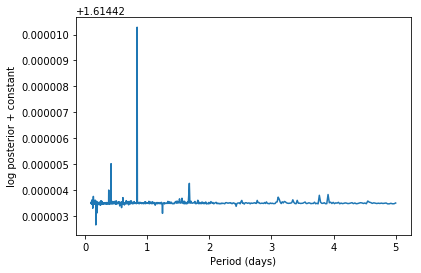

In [10]:
plt.plot(periods, prob)
plt.ylabel("log posterior + constant")
plt.xlabel("Period (days)");

In [11]:
best_period # correct period: 0.837495

0.83792535000369317

The period estimate defaults to units of days.

Now, let's use the `fold` method passing along the `best_period`:

In [12]:
fold = flat.fold(period=best_period)

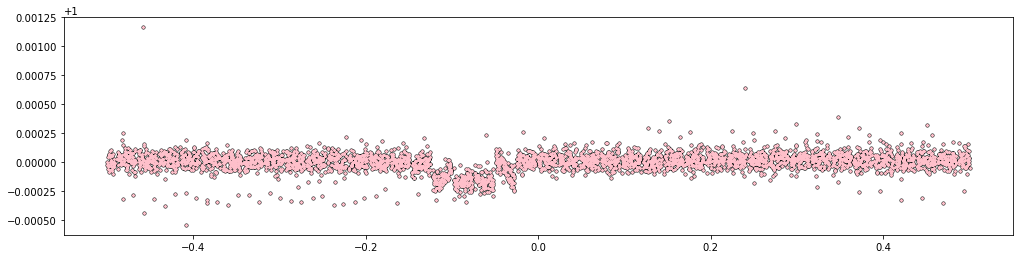

In [13]:
plt.figure(figsize=(17, 4))
plt.plot(fold.time, fold.flux, 'ko', markersize=3)
plt.plot(fold.time, fold.flux, 'o', color='pink', markersize=2);

And we can clearly see the transit of Kepler-10b.